In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import svm
from sklearn.feature_selection import RFE

In [2]:
# data from https://www.kaggle.com/hugodarwood/epirecipes/data
raw_data = pd.read_csv('~/Desktop/Data_Science/epicurious/epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

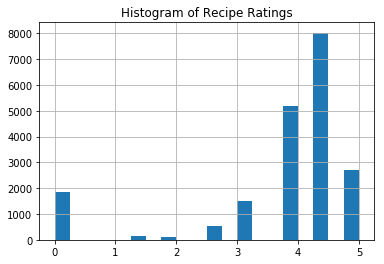

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [ ]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

In [ ]:
plt.scatter(Y, svr.predict(X))

## Challenge

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Let's

In [3]:
# create new binary classification for good ratings above 3.5

raw_data['good_rating'] = 0
raw_data.loc[raw_data['rating'] > 3.5, 'good_rating'] = 1

Y = raw_data.good_rating

In [4]:
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)

In [5]:
# identify most frequently used incredients

frequency = pd.DataFrame()
column_data = []

def category_test(i):
    data = pd.DataFrame({"item": [i], "counts": [X[i].sum()]})
    return data

for i in X.columns:
    result = category_test(i)
    column_data.append(result)
frequency = pd.concat(column_data, ignore_index=True)

frequent = frequency.loc[frequency['counts'] > frequency['counts'].quantile(.75)]
frequent.head()

,counts,item
8,835.0,alcoholic
9,584.0,almond
16,1372.0,appetizer
17,666.0,apple
22,278.0,arugula


In [6]:
# create subset of features with most frequently cited variables

frequent_list = frequent['item'].tolist()
X = X.filter(items=frequent_list)

In [46]:
X.shape

(20052, 169)

In [47]:
# fit SVM model with classifier target
svc = svm.SVC()
#svc = svm.SVC(kernel='linear')

svc.fit(X,Y)

score = cross_val_score(svc, X, Y, cv=5)

print("SVM Model \n")
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))
print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))

SVM Model 

Cross Validation Score Range: 0.80 to 0.80

Cross Validation mean of: 0.80 (+/- 0.00)


Using the most frequently appearing features (75th percentile and above), the fit is a reliable 80%, but that's with almost 170 features.  Let's try to narrow it down.

In [48]:
# select 10 most frequently present features
top_10 = frequent.nlargest(10, 'counts')
print(top_10)

     counts               item
57   9355.0        bon appétit
453  8390.0        peanut free
574  8088.0           soy free
624  7044.0      tree nut free
636  6846.0         vegetarian
240  6648.0            gourmet
310  6175.0             kosher
462  6042.0        pescatarian
502  5372.0       quick & easy
654  4906.0  wheat/gluten-free


In [56]:
top_10_list = top_10['item'].tolist()
X = X.filter(items=top_10_list)

In [59]:
def svc_model(data, target):
    #fit model
    svc.fit(data,target)
    #score accuracy
    score = cross_val_score(svc, data, target, cv=10)
    #return results
    print("SVM Model \n")
    print("Cross Validation Scores:\n", score)
    print("\nCross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))
    print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
    

In [58]:
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.79312064 0.79312064 0.79312064 0.79312064 0.79312064 0.79351621
 0.79351621 0.79341317 0.79341317 0.79341317]
Cross Validation Score Range: 0.79 to 0.79

Cross Validation mean of: 0.79 (+/- 0.00)


Using only the top ten most frequent features, our accuracy is reduced by 1% to 79%.  Let's try a few more features.

In [60]:
# select 30 most frequently present features
top_30 = frequent.nlargest(30, 'counts')
top_30_list = top_30['item'].tolist()
X = X.filter(items=top_30_list)

In [61]:
#test model with revised features
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.79312064 0.79312064 0.79312064 0.79312064 0.79312064 0.79351621
 0.79351621 0.79341317 0.79341317 0.79341317]

Cross Validation Score Range: 0.79 to 0.79

Cross Validation mean of: 0.79 (+/- 0.00)


That didn't do any better.  Let's try try less frequently occurring features

In [63]:
# identify features with frequency below mean
infrequent = frequency.loc[frequency['counts'] < frequency['counts'].quantile(.5)]
infrequent_list = infrequent['item'].tolist()
#reset X
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)
#filter X for infrequent features
X = X.filter(items=infrequent_list)

In [65]:
X.shape

(20052, 336)

In [67]:
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.79312064 0.79312064 0.79312064 0.79312064 0.79312064 0.79351621
 0.79351621 0.79341317 0.79341317 0.79341317]

Cross Validation Score Range: 0.79 to 0.79

Cross Validation mean of: 0.79 (+/- 0.00)


The infrequent features are just as powerful as frequent featres.  Let's try another method.

In [68]:
# recursive feature selection

# redefine data
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)

linear_svc = svm.SVC(kernel='linear')

selector = RFE(svc)
selector = selector.fit(X, Y)

rankings = pd.DataFrame({'Features': data.columns, 'Ranking' : selector.ranking_})


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [ ]:
high_rank = rankings.loc[rankings['Ranking'] < 2]
print('High Ranked Features:\n', high_rank)

In [4]:
# redefine data
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)

In [ ]:
# lasso for feature selection

lasso_results = pd.DataFrame()

def lambda_test(value):
    #Test lambda values
    lasso = LogisticRegression(C=value, penalty="l1")  
    score = cross_val_score(lasso, X, Y, cv=10)
    #return dataframe of r-squared for each lambda value
    data = pd.DataFrame({"lambda_value": [value], "score": [score.mean()], "std": [score.std()]})
    return data

appended_data = []
lambda_range = np.arange(0.01, 5, 0.01)
for i in lambda_range:
    result = lambda_test(i)
    appended_data.append(result)
lasso_results = pd.concat(appended_data, ignore_index=True)



In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lasso_results['lambda_value'], lasso_results['score'], label="R-Squared")
plt.xlabel('Lambda Value')
plt.ylabel('R-squared Value')
plt.legend(loc='best') 
plt.title('Lasso Lambda Test')

plt.subplot(1, 2, 2)
plt.plot(lasso_results['lambda_value'], lasso_results['std'], label="STD")
plt.xlabel('Lambda Value')
plt.ylabel('STD Value')
plt.legend(loc='best') 
plt.title('Lasso Lambda Test')

plt.show()

print('Lasso Lambda Value(s) with lowest STD:')
lasso_results.loc[lasso_results['std'] == lasso_results['std'].min()]

In [ ]:
# fit optimized lasso model
lass = LogisticRegression(C=0.01, penalty="l1")
lassfit = lass.fit(X, y)

In [ ]:
#create dataframe of features and coefficients
feature_test = pd.DataFrame({"feature": [i], "counts": [X[i].sum()]})

#remove features with coefficients of 0
X = 

In [ ]:
lassfit.coef_